In [9]:
# Manage warning messages

import os, warnings
warnings.filterwarnings('ignore')

In [10]:
# Import necessary libraries

import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA

[*********************100%%**********************]  1 of 1 completed


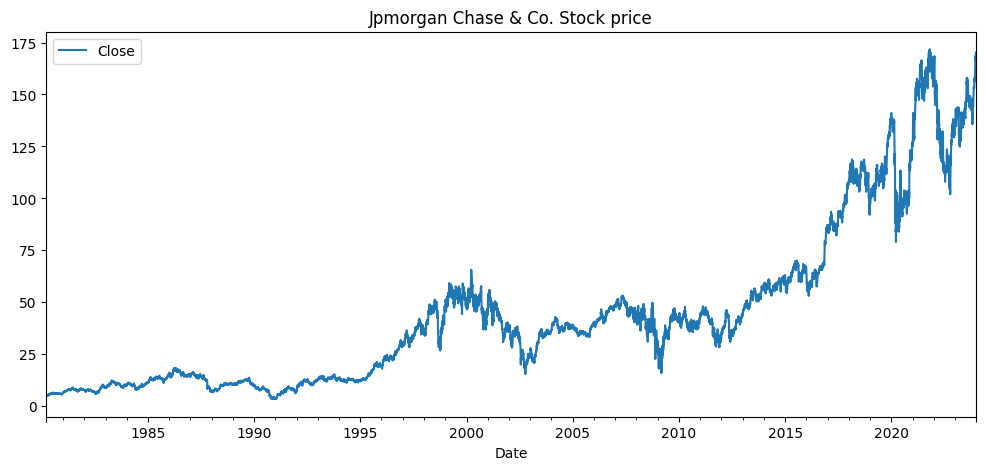

In [7]:
# Download and preprocess stock data as described in 5.1

df = yf.download('JPM', start='1980-01-01', end='2024-01-02')
df.index = pd.to_datetime(df.index)
df = df.asfreq('B')
df['Close'].interpolate(method='linear', inplace=True)

df.Close.plot(figsize = (12, 5), legend= True)
plt.title('Jpmorgan Chase & Co. Stock price')
plt.show()

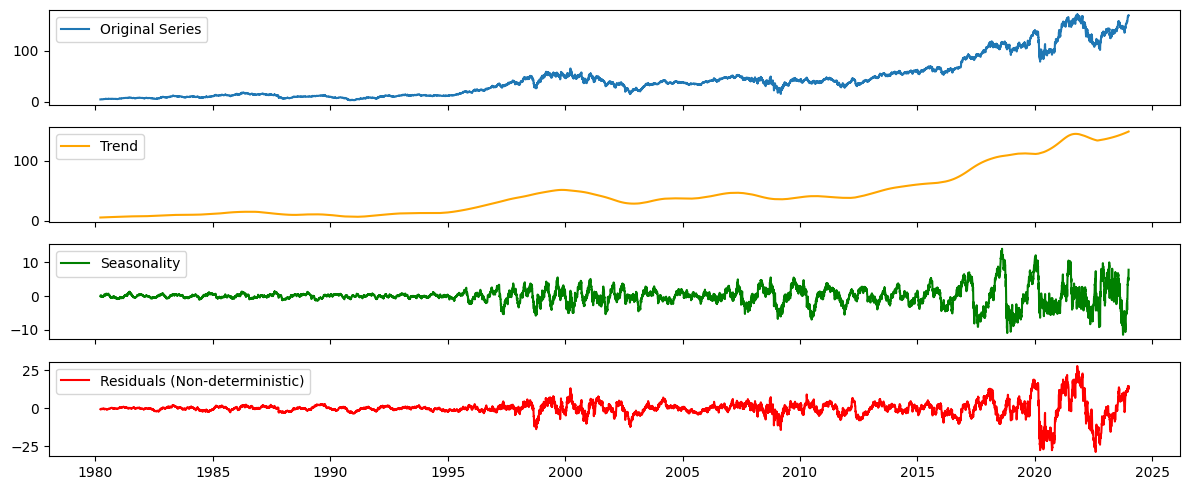

In [12]:
# Decompose the time series (Figure 1)

period = 365
stl = STL(df['Close'], period=period)
result = stl.fit()

trend_component = result.trend
seasonal_component = result.seasonal
residual_component = result.resid

fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
axes[0].plot(df.index, df['Close'], label='Original Series')
axes[0].legend()

axes[1].plot(df.index, trend_component, label='Trend', color='orange')
axes[1].legend()

axes[2].plot(df.index, seasonal_component, label='Seasonality', color='green')
axes[2].legend()

axes[3].plot(df.index, residual_component, label='Residuals (Non-deterministic)', color='red')
axes[3].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Dataframe details

df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,11041.000000,11041.000000,11041.000000,11425.000000,11041.000000,1.104100e+04
mean,43.281564,44.477710,43.485151,44.047106,31.636839,1.199405e+07
std,39.553804,39.194384,38.507719,38.873724,37.686086,1.650189e+07
min,0.000000,3.625000,3.208333,3.375000,1.067557,1.147500e+04
25%,12.666667,12.791667,12.541667,12.666667,3.920048,1.397100e+06
50%,36.540001,37.000000,36.000000,36.549999,21.233116,7.821900e+06
75%,53.666668,54.250000,52.889999,53.630001,33.741528,1.455320e+07
max,172.710007,172.960007,170.539993,171.779999,167.347443,2.172942e+08


In [13]:
# Make df stationary: apply differencing and transformations (Section 5.1)

df['close_diff'] = df['Close'] - df['Close'].shift(1)

df['ts_log'] = np.log(df['Close'])

df['ts_sqrt'] = np.log(df['Close'])

df['ts_log_diff'] = df['ts_log'] - df['ts_log'].shift(1)

df['ts_sqrt_diff'] = df['ts_sqrt'] - df['ts_sqrt'].shift(1)

In [14]:
df = df.dropna()  # Drop rows with NaN values

Text(0.5, 1.0, 'After Log differencing')

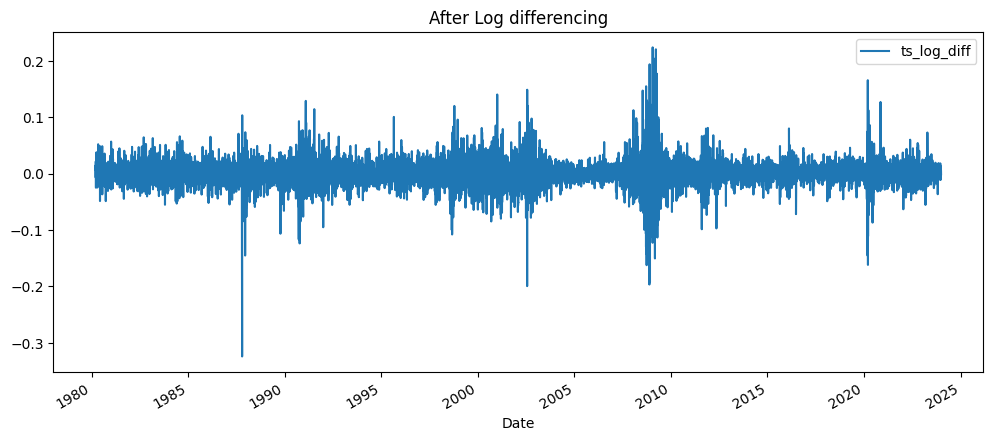

In [15]:
# Plot the log-differenced series

df.plot(y = ['ts_log_diff'], figsize=(12, 5))
plt.title('After Log differencing')

In [16]:
# ADF test (Table 1)

from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
    adftest = adfuller(dataset, autolag = 'AIC') # AIC helps to determine optimal number of lags
    print("ADF : ",adftest[0])
    print("P-Value : ", adftest[1])
    print("Num Of Lags : ", adftest[2])
    print("Observations used For ADF Regression:", adftest[3])
    print("Critical Values :")
    for key, val in adftest[4].items():
        print("\t",key, ": ", val)
    if adftest[1] < 0.05:
        print("The series is stationary")
    else:
        print("The series is not stationary")


In [29]:
# Test every transformed series whether it is stationary or not using ADF and KPSS test

adf_test(df.ts_log_diff.dropna())

ADF :  -18.058678321995906
P-Value :  2.625790703518861e-30
Num Of Lags :  33
Observations used For ADF Regression: 11006
Critical Values :
	 1% :  -3.430944296367785
	 5% :  -2.861802646286553
	 10% :  -2.5669098014923155
The series is stationary


In [18]:
adf_test(df.ts_sqrt_diff.dropna())

ADF :  -18.058678321995906
P-Value :  2.625790703518861e-30
Num Of Lags :  33
Observations used For ADF Regression: 11006
Critical Values :
	 1% :  -3.430944296367785
	 5% :  -2.861802646286553
	 10% :  -2.5669098014923155
The series is stationary


In [19]:
adf_test(df.ts_log.dropna())

ADF :  -1.092068166298425
P-Value :  0.7182246410527857
Num Of Lags :  34
Observations used For ADF Regression: 11005
Critical Values :
	 1% :  -3.4309443503827852
	 5% :  -2.861802670155822
	 10% :  -2.5669098141978752
The series is not stationary


In [20]:
adf_test(df.ts_sqrt.dropna())

ADF :  -1.092068166298425
P-Value :  0.7182246410527857
Num Of Lags :  34
Observations used For ADF Regression: 11005
Critical Values :
	 1% :  -3.4309443503827852
	 5% :  -2.861802670155822
	 10% :  -2.5669098141978752
The series is not stationary


In [21]:
adf_test(df.Close.dropna())

ADF :  0.50630624685938
P-Value :  0.9850635144762392
Num Of Lags :  39
Observations used For ADF Regression: 11000
Critical Values :
	 1% :  -3.4309446206051337
	 5% :  -2.861802789567273
	 10% :  -2.5669098777603305
The series is not stationary


In [22]:
# KPSS test

from statsmodels.tsa.stattools import kpss
def kpss_test(dataset, **kw):
    kpsstest = kpss(dataset, **kw)
    print("KPSS Statistic:", kpsstest[0])
    print("p-value:", kpsstest[1])
    print("num lags:", kpsstest[2])
    print('Critial Values:')
    for key, value in kpsstest[3].items():
        print("\t",key, ": ", value)
    if kpsstest[1] > 0.05:
        print("The series is stationary")
    else:
        print("The series is not stationary")


In [23]:
kpss_test(df.ts_log_diff.dropna())

KPSS Statistic: 0.03430872680508418
p-value: 0.1
num lags: 16
Critial Values:
	 10% :  0.347
	 5% :  0.463
	 2.5% :  0.574
	 1% :  0.739
The series is stationary


In [24]:
kpss_test(df.ts_sqrt_diff.dropna())

KPSS Statistic: 0.03430872680508418
p-value: 0.1
num lags: 16
Critial Values:
	 10% :  0.347
	 5% :  0.463
	 2.5% :  0.574
	 1% :  0.739
The series is stationary


In [25]:
kpss_test(df.ts_log.dropna())

KPSS Statistic: 15.47992786806498
p-value: 0.01
num lags: 61
Critial Values:
	 10% :  0.347
	 5% :  0.463
	 2.5% :  0.574
	 1% :  0.739
The series is not stationary


In [26]:
kpss_test(df.ts_sqrt.dropna())

KPSS Statistic: 15.47992786806498
p-value: 0.01
num lags: 61
Critial Values:
	 10% :  0.347
	 5% :  0.463
	 2.5% :  0.574
	 1% :  0.739
The series is not stationary


In [27]:
kpss_test(df.Close.dropna())

KPSS Statistic: 13.083326904374148
p-value: 0.01
num lags: 61
Critial Values:
	 10% :  0.347
	 5% :  0.463
	 2.5% :  0.574
	 1% :  0.739
The series is not stationary


In [28]:
df = df.reset_index(drop=True)

In [32]:
# Select the log-differenced series for modeling and preprocess the data

data = df['ts_log_diff']

train_data = data[:int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]

In [33]:
# Build and fit the AutoRegressive model

model = AutoReg(train_data, lags=200)
model_fit = model.fit()

In [34]:
# Forecast 3 future values and transform back to original scale

future_forecast_ar = model_fit.predict(start=len(data), end=len(data) + 2)
forecasted_log_prices = pd.Series(df['ts_log'].iloc[-1], index=future_forecast_ar.index).add(future_forecast_ar.cumsum(), fill_value=0)
forecasted_stock_prices = np.exp(forecasted_log_prices)

In [35]:
# Fetch actual stock prices for comparison

actual_df = yf.download('JPM', start='2024-01-02', end='2024-01-05')
actual_stock_prices = actual_df['Close']


[*********************100%%**********************]  1 of 1 completed


In [36]:
actual_stock_prices

,Close
Date,
2024-01-02,172.080002
2024-01-03,171.330002
2024-01-04,171.410004


In [38]:
rmse_ar = np.sqrt(mean_squared_error(actual_stock_prices.values, forecasted_stock_prices))
mape_ar = mean_absolute_percentage_error(actual_stock_prices.values, forecasted_stock_prices)

print(f'Root Mean Squared Error for AR model: {rmse_ar}')
print(f'Mean Absolute Percentage Error for AR model: {mape_ar}')

Root Mean Squared Error for AR model: 1.4631834449790027
Mean Absolute Percentage Error for AR model: 0.008249856620904428


In [ ]:
actual_df['Close']

Date
2024-01-02    172.080002
2024-01-03    171.330002
2024-01-04    171.410004
Name: Close, dtype: float64

In [40]:
predicted_stock_prices_ar = pd.Series(forecasted_stock_prices.values, index=actual_df.index[:len(forecasted_stock_prices)+1])

### Prediction using Moving Average model

In [41]:
# Split the data into training and testing sets

train_size = int(len(df) * 0.8)
train, test = df['ts_log_diff'][:train_size], df['ts_log_diff'][train_size:]

In [42]:
# Function to fit a Moving Average (MA) model

def fit_ma_model(train, q):
    predictions = []
    for t in range(q, len(train)):
        prediction = train.iloc[t-q:t].mean()
        predictions.append(prediction)
    return np.array(predictions)


In [43]:
q = 77 # time steps
next = 3 # Define the number of future days to predict

In [44]:
# Fit the MA model and make predictions

predictions_ma_train = fit_ma_model(train, q)
predictions_ma_test = fit_ma_model(pd.concat([train.iloc[-q:], test]), q)[-len(test):]
forecasted_ma = fit_ma_model(df['ts_log_diff'], q)[-next:]

In [45]:
# Transform the forecasted log prices back to the original scale

forecasted_log_prices_ma = pd.Series(df['ts_log'].iloc[-1], index=pd.date_range(start=df.index[-1], periods=next, freq='B')).add(forecasted_ma.cumsum(), fill_value=0)
forecasted_stock_prices_ma = np.exp(forecasted_log_prices_ma)
predicted_stock_prices_ma = pd.Series(forecasted_stock_prices_ma.values, index=actual_df.index[:len(forecasted_stock_prices_ma)])

In [46]:
# Forecast future 3 days using MA model

forecasted_ma = fit_ma_model(df['ts_log_diff'], q)[-next:]
forecasted_log_prices_ma = pd.Series(df['ts_log'].iloc[-1], index=pd.date_range(start=df.index[-1], periods=next, freq='B')).add(forecasted_ma.cumsum(), fill_value=0)
forecasted_stock_prices_ma = np.exp(forecasted_log_prices_ma)
predicted_stock_prices_ma = pd.Series(forecasted_stock_prices_ma.values, index=actual_df.index[:len(forecasted_stock_prices_ma)])

In [47]:
predicted_stock_prices_ma

,0
Date,
2024-01-02,170.423255
2024-01-03,170.779432
2024-01-04,171.146430


In [49]:
# Evaluate the MA model's performance

rmse_ma = np.sqrt(mean_squared_error(actual_stock_prices.values, predicted_stock_prices_ma))
mape_ma = mean_absolute_percentage_error(actual_stock_prices.values, predicted_stock_prices_ma)

print(f'Root Mean Squared Error for MA model: {rmse_ma}')
print(f'Mean Absolute Percentage Error for MA model: {mape_ma}')


Root Mean Squared Error for MA model: 1.0193805236474227
Mean Absolute Percentage Error for MA model: 0.004792987133435044


### Evaluate the ARIMA model's performance

In [58]:
predicted_stock_prices_forecast_arima = [170.46642711, 170.54196774, 170.76750593] # Imported from the result of ARIMA notebook
predicted_stock_prices_arima = pd.Series(predicted_stock_prices_forecast_arima, index=actual_df.index[:len(predicted_stock_prices_forecast_arima)+1])

In [59]:
# Evaluate the ARIMA model's performance

rmse_arima = np.sqrt(mean_squared_error(actual_df['Close'].values, predicted_stock_prices_arima))
mape_arima = mean_absolute_percentage_error(actual_df['Close'].values, predicted_stock_prices_arima)

print(f'Root Mean Squared Error for ARIMA model: {rmse_arima}')
print(f'Mean Absolute Percentage Error for ARIMA model: {mape_arima}')

Root Mean Squared Error for ARIMA model: 1.1011243412767953
Mean Absolute Percentage Error for ARIMA model: 0.005908235520038961


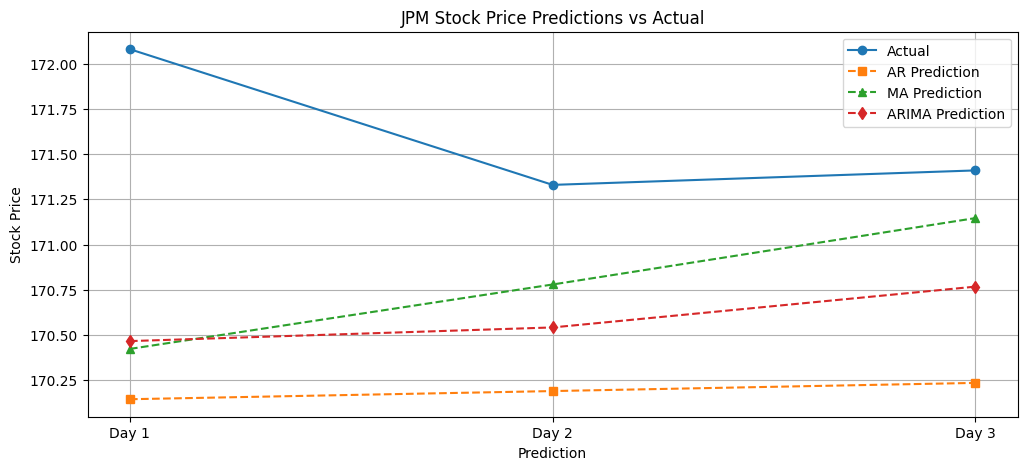

In [60]:
# Plot the forecasted prices against the actual prices for AR, MA and ARIMA

days = ["Day 1", "Day 2", "Day 3"]
actual = actual_stock_prices # Actual prices
ar_prediction = predicted_stock_prices_ar # AR prediction
ma_prediction = predicted_stock_prices_ma # MA prediction
arima_prediction = [170.46642711, 170.54196774, 170.76750593] # ARIMA prediction

plt.figure(figsize=(12, 5))

plt.plot(days, actual, marker='o', label='Actual', linestyle='-')
plt.plot(days, ar_prediction, marker='s', label='AR Prediction', linestyle='--')
plt.plot(days, ma_prediction, marker='^', label='MA Prediction', linestyle='--')
plt.plot(days, arima_prediction, marker='d', label='ARIMA Prediction', linestyle='--')

plt.title('JPM Stock Price Predictions vs Actual')
plt.xlabel('Prediction')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.show()

### Evaluate the RNN model's performance

In [64]:
predicted_stock_prices_forecast_rnn = [236.50453, 157.90698, 114.85618] # Imported from the result of RNN notebook
predicted_stock_prices_rnn = pd.Series(predicted_stock_prices_forecast_rnn, index=actual_df.index[:len(predicted_stock_prices_forecast_rnn)+1])

In [65]:
# Evaluate RNN model's performance

rmse_rnn = np.sqrt(mean_squared_error(actual_df['Close'].values, predicted_stock_prices_rnn))
mape_rnn = mean_absolute_percentage_error(actual_df['Close'].values, predicted_stock_prices_rnn)

print(f'Root Mean Squared Error for ARIMA model: {rmse_rnn}')
print(f'Mean Absolute Percentage Error for ARIMA model: {mape_rnn}')

Root Mean Squared Error for ARIMA model: 50.09668091358668
Mean Absolute Percentage Error for ARIMA model: 0.26088870732322694


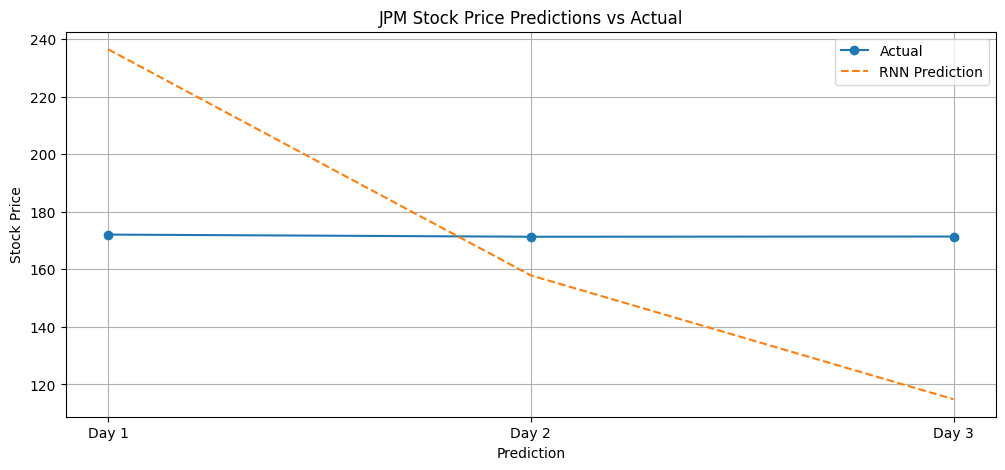

In [66]:
# Plot the forecasted prices against the actual prices for RNN

days = ["Day 1", "Day 2", "Day 3"]
rnn_prediction = predicted_stock_prices_rnn

plt.figure(figsize=(12, 5))

plt.plot(days, actual, marker='o', label='Actual', linestyle='-')
plt.plot(days, rnn_prediction, label='RNN Prediction', linestyle='--')

plt.title('JPM Stock Price Predictions vs Actual')
plt.xlabel('Prediction')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.show()
